# Detecting Community Structure in a GitHub Developer Network via Graph Analytics and Unsupervised Learning

This notebook investigates how community structure emerges in a large GitHub developer network.

We examine the network from two complementary perspectives:

- **Connectivity-based structure** (graph partitioning and modularity)
- **Embedding-based similarity** (Node2Vec + clustering)

The central question is:

> Do edge-based communities align with structural similarity learned through representation learning?

---

## Dataset

Source: https://archive.ics.uci.edu/dataset/588/github+musae

The dataset contains a snapshot (June 2019) of a large GitHub developer social network.

- **37,700 nodes** — developers who starred at least 10 repositories  
- **289,003 edges** — mutual follower relationships  
- Binary node label:
  - Web developer  
  - Machine learning developer  

Files used:

- `musae_git_edges.csv` — edge list  
- `musae_git_target.csv` — developer labels  
- `musae_git_features.json` — 128-dimensional node attributes  

The graph is undirected and forms a single connected component.

---

## Analytical Objectives

This notebook addresses three related questions:

### 1. Structural Properties
- Is the network hub-dominated?
- How concentrated is influence?
- How robust is the network to removal of central nodes?

### 2. Connectivity-Based Communities
- Can **Kernighan–Lin bisection** identify meaningful partitions?
- How strong is the modular separation?

### 3. Embedding-Based Structure
- What structural patterns can **Node2Vec** capture?
- Do learned embeddings produce clearer cluster structure?
- How do embedding-based clusters compare to graph partitions?

---

## Methodological Approach

The workflow proceeds in four stages:

1. Graph construction and structural diagnostics  
2. Community detection via **Kernighan–Lin**  
3. Node embedding with **Node2Vec (64 dimensions)**  
4. Dimensionality reduction (**PCA**, **t-SNE**) and clustering (**K-Means**)  

This progression allows us to compare classical network partitioning with modern representation learning within the same system.

## 1. Load data and build graph

### 1.1 Load data (edges, node labels, node features)


We load the GitHub follower edge list, node labels (`ml_target`), and per-node feature vectors. A small cleanup step removes any malformed edge rows before constructing the graph.

In [2]:
import pandas as pd
import networkx as nx
import json
import random

random.seed(55)

# File paths
edges_file = "data/musae_git_edges.csv"
nodes_file = "data/musae_git_target.csv"
features_file = "data/musae_git_features.json"

# Load and clean the edge list
edges_raw = pd.read_csv(edges_file, names=["id_1", "id_2"], dtype=str)
edges_clean = edges_raw[edges_raw["id_1"].str.isdigit() & edges_raw["id_2"].str.isdigit()]
edges_clean = edges_clean.astype({"id_1": int, "id_2": int})

# Load node attributes
nodes = pd.read_csv(nodes_file)
nodes["id"] = nodes["id"].astype(int)

# Load node features
with open(features_file, "r") as f:
    features = json.load(f)

### 1.2 Build the graph and attach node metadata

We construct an undirected graph from mutual follower relationships, then attach:

- `name` and `ml_target` (node label)
- `features` (128-d feature vector, when available)

Finally, we print a compact summary to sanity-check graph size and connectivity.

In [3]:
# Create the graph
G = nx.from_pandas_edgelist(edges_clean, source="id_1", target="id_2")

# Add node attributes
node_attributes = nodes.set_index('id')[['name', 'ml_target']].to_dict('index')
nx.set_node_attributes(G, node_attributes)

# Add node features
for node_id, feature_list in features.items():
    if int(node_id) in G.nodes:
        G.nodes[int(node_id)]['features'] = feature_list

# Ensure all nodes in 'nodes' are present in the graph
for node_id in nodes['id']:
    if node_id not in G:
        G.add_node(node_id, **node_attributes.get(node_id, {}))

# Summarize the dataset
summary = {
    "Number of Nodes": G.number_of_nodes(),
    "Number of Edges": G.number_of_edges(),
    "Density": nx.density(G),
    "Number of Connected Components": nx.number_connected_components(G),
    "Average Degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
    "Maximum Degree": max(dict(G.degree()).values()),
}

print("Graph Summary:")
for key, value in summary.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

# Graph Density
density = nx.density(G)
print(f"Graph Density: {density:.4f}")

# Calculate the number of connected components
connected_components = list(nx.connected_components(G))
print(f"Number of Connected Components: {len(connected_components)}")

# Size of the largest connected component
largest_component_size = max(len(component) for component in connected_components)
print(f"Size of the Largest Connected Component: {largest_component_size}")

# Display a sample node with attributes
sample_node = list(G.nodes)[0]
print("\nSample Node Attributes:")
print(f"Node {sample_node}: {G.nodes[sample_node]}")

Graph Summary:
Number of Nodes: 37700
Number of Edges: 289003
Density: 0.00
Number of Connected Components: 1
Average Degree: 15.33
Maximum Degree: 9458
Graph Density: 0.0004
Number of Connected Components: 1
Size of the Largest Connected Component: 37700

Sample Node Attributes:
Node 0: {'name': 'Eiryyy', 'ml_target': 0, 'features': [1574, 3773, 3571, 2672, 2478, 2534, 3129, 3077, 1171, 2045, 1539, 902, 1532, 2472, 1122, 2480, 3098, 2115, 1578]}


**Commentary:** 

- The graph is large and sparse (density ≈ `0.0004`), which is typical for social networks.
- There is one connected component spanning all nodes, meaning the network is fully connected by some path.
- The max degree (~9,458) indicates a strong hub presence: a small number of developers act as major connectivity centers.
- The sample node output confirms attributes are attached correctly (`name`, `ml_target`, `features`).

## 2. Exploratory Analysis

Before applying community detection or embedding methods, we examine the structural properties of the network. 

Understanding the baseline topology of the graph helps answer key questions:

- Is the network centralized around a few influential hubs?
- Do nodes form tightly-knit clusters?
- How concentrated is influence across the network?

We focus on three core structural measures as follows.

### 2.1 Class balance

First we check class balance in the node labels (`ml_target`).

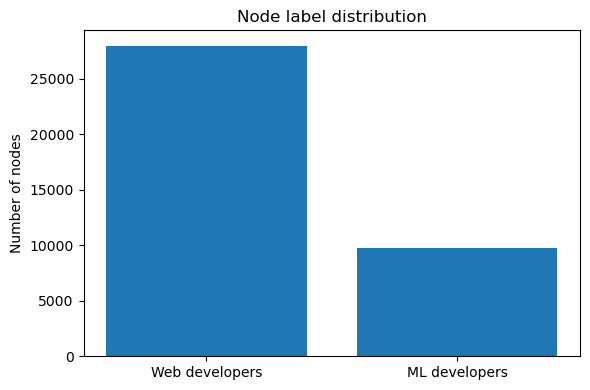

Web developers: 27,961 (74.2%)
ML developers:  9,739 (25.8%)


In [35]:
import matplotlib.pyplot as plt
import numpy as np

ml_developers = sum(1 for n in G.nodes if G.nodes[n].get("ml_target") == 1)
web_developers = sum(1 for n in G.nodes if G.nodes[n].get("ml_target") == 0)

labels = ["Web developers", "ML developers"]
counts = [web_developers, ml_developers]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.ylabel("Number of nodes")
plt.title("Node label distribution")
plt.tight_layout()
plt.savefig("images/label_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Web developers: {web_developers:,} ({web_developers/(web_developers+ml_developers):.1%})")
print(f"ML developers:  {ml_developers:,} ({ml_developers/(web_developers+ml_developers):.1%})")

**Commentary:** 

The dataset is imbalanced (web developers are the majority). This matters later when interpreting clusters or any downstream classification performance.

### 2.2 Degree Distribution

Degree is the number of connections a node has.  In social networks, degree often follows a *heavy-tailed* distribution, meaning:
- Most nodes have few connections
- A small number of nodes act as hubs with very high connectivity

Plotting the degree distribution on a *log-log scale* helps reveal this structure clearly.

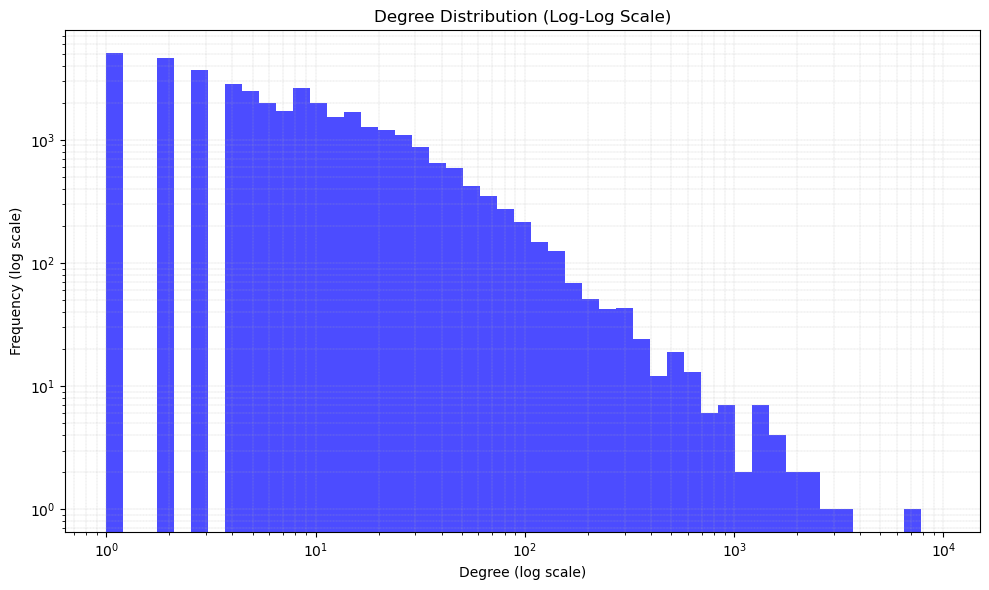

In [34]:
# Plot degree distribution (log-log Scale)
degrees = [d for _, d in G.degree()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), 50), color="blue", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.title("Degree Distribution (Log-Log Scale)", fontsize=12)
plt.xlabel("Degree (log scale)", fontsize=10)
plt.ylabel("Frequency (log scale)", fontsize=10)
plt.grid(True, which="both", linestyle="--", linewidth=0.2)
plt.tight_layout()
plt.savefig("images/degree_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

**Commentary:** 

The log-log plot shows a clear heavy-tailed pattern:

- Most developers have relatively few connections.
- A very small number of nodes have extremely high degree (thousands of connections).

This suggests the presence of *hub nodes*, which are likely to play a dominant role in information flow and connectivity across the network.

### 2.3 Clustering Coefficient

The clustering coefficient measures how interconnected a node’s neighbors are.

- A high value means a node’s neighbors tend to connect to each other (tight local communities).
- A low value suggests sparse local structure.

This helps assess whether the network is composed of tightly-knit subgroups or loosely connected individuals.

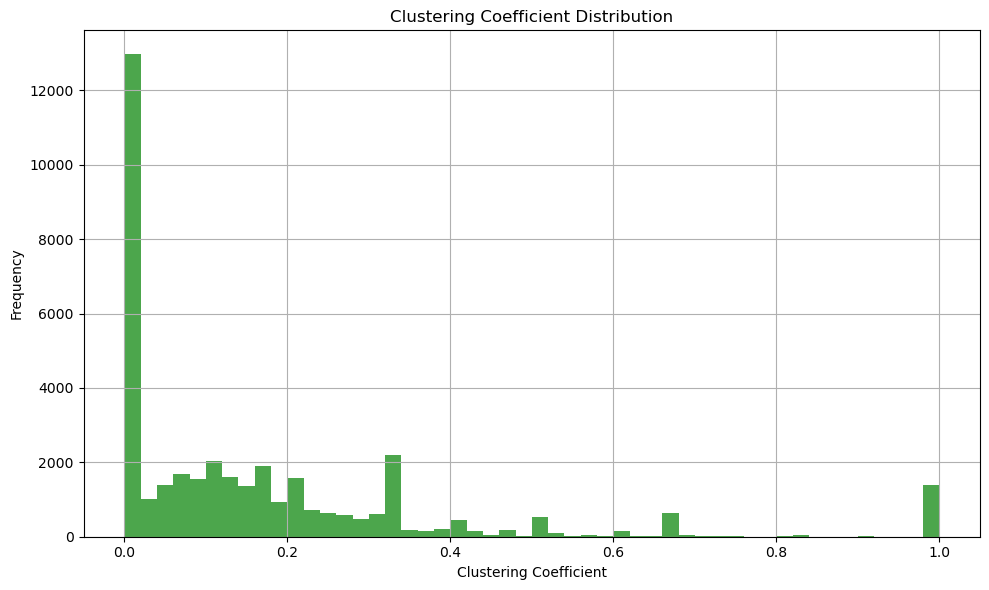

In [33]:
# Plot the clustering coefficients distribution
clustering = list(nx.clustering(G).values())
plt.figure(figsize=(10, 6))
plt.hist(clustering, bins=50, color="green", alpha=0.7)
plt.title("Clustering Coefficient Distribution", fontsize=12)
plt.xlabel("Clustering Coefficient", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("images/clustering_coeffecient.png", dpi=300, bbox_inches="tight")
plt.show()

**Commentary:**

The distribution shows that:

- A large portion of nodes have low clustering coefficients.
- Only a minority belong to tightly interconnected local neighborhoods.

This suggests that while some localized communities exist, much of the network is not strongly clustered. 

The network appears to be hub-driven rather than composed of many tightly closed triangles.

### 2.4 Eigenvector Centrality

While degree measures how many connections a node has, eigenvector centrality measures how important those connections are. 

A node has high eigenvector centrality if:
- It connects to many nodes
- And those nodes themselves are highly connected

This captures *influence* rather than just popularity. 

Together, these metrics provide a structural foundation before moving into community detection and embedding analysis.

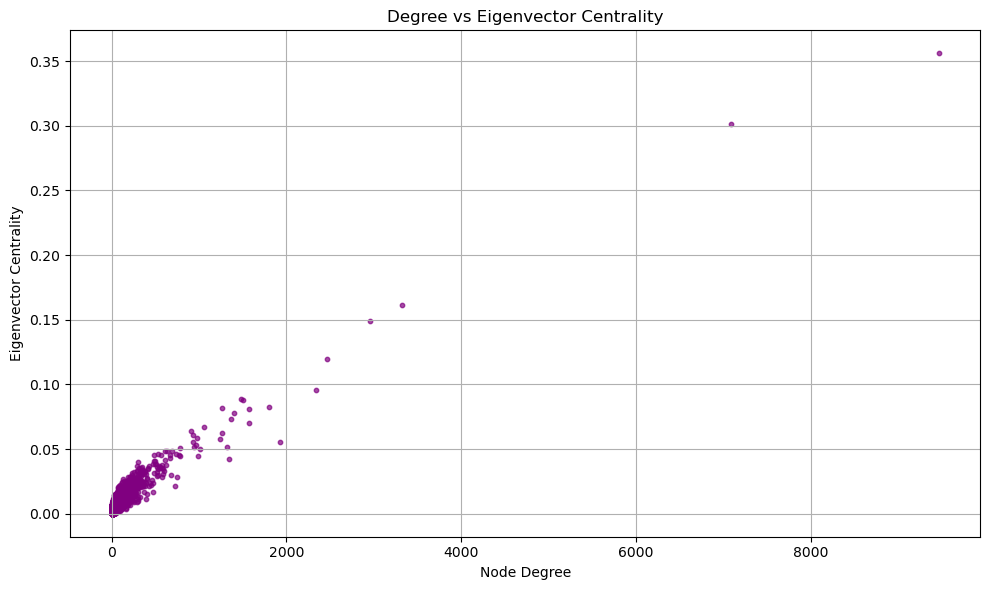

In [32]:
# Calculate eigenvector centrality for nodes
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
centrality_values = list(eigenvector_centrality.values())

# Plot Degree vs Eigenvector centrality
degrees = [d for _, d in G.degree()]
plt.figure(figsize=(10, 6))
plt.scatter(degrees, centrality_values, alpha=0.7, color="purple", s=10)
plt.title("Degree vs Eigenvector Centrality", fontsize=12)
plt.xlabel("Node Degree", fontsize=10)
plt.ylabel("Eigenvector Centrality", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("images/degree_v_eigenvector_centrality.png", dpi=300, bbox_inches="tight")
plt.show()

**Commentary:**

The scatter plot reveals a strong positive relationship between degree and eigenvector centrality:

- Nodes with higher degree tend to have higher centrality.
- However, centrality grows disproportionately for the largest hubs.

This indicates that influence is highly concentrated: a few nodes are not only well-connected, but connected to other important nodes.

This reinforces the hypothesis that key hubs dominate structural influence.

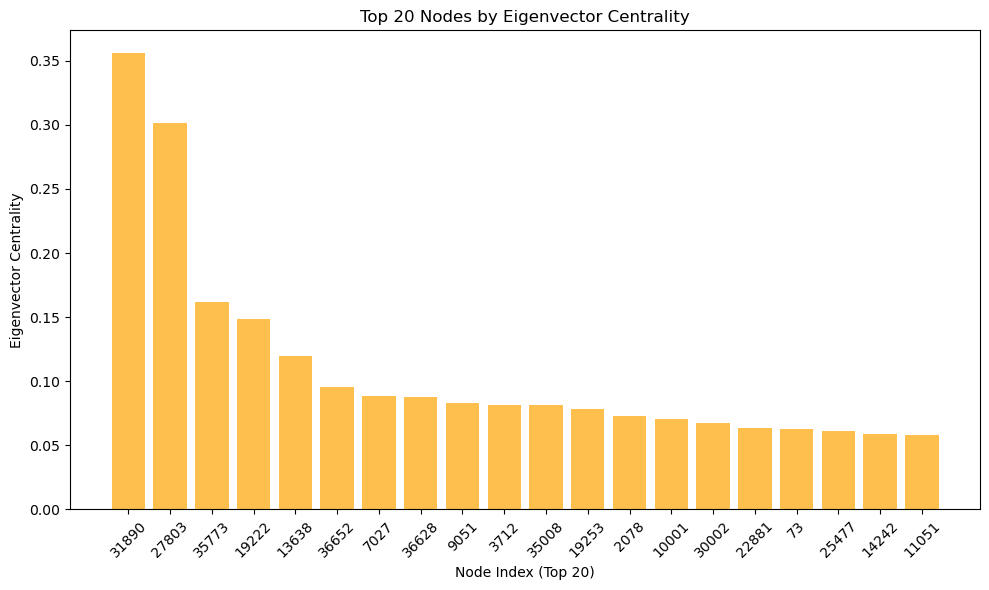

In [31]:
# Plot top 20 nodes by eigenvector centrality
top_eigenvector_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
plt.figure(figsize=(10, 6))
top_nodes = [n for n, _ in top_eigenvector_nodes]
top_eigenvector = [c for _, c in top_eigenvector_nodes]
plt.bar(range(len(top_nodes)), top_eigenvector, color="orange", alpha=0.7)
plt.title("Top 20 Nodes by Eigenvector Centrality", fontsize=12)
plt.xlabel("Node Index (Top 20)", fontsize=10)
plt.ylabel("Eigenvector Centrality", fontsize=10)
plt.xticks(range(len(top_nodes)), top_nodes, rotation=45)
plt.tight_layout()
plt.savefig("images/top_20_nodes.png", dpi=300, bbox_inches="tight")
plt.show()

**Commentary:**

The top two nodes stand out significantly above the rest. These nodes likely act as bridges or anchor points in the network. A very small number of developers occupy structurally dominant positions.

This observation directly motivates the later analysis:
- Subgraph creation around top nodes
- Community detection via KL
- Node2Vec embedding of their neighborhoods

## 3. Community Detection

### 3.1 Identifying Structurally Dominant Nodes

In Section 2, eigenvector centrality revealed a highly skewed influence structure. We now focus on the two most influential nodes in the network.

We extract the top two nodes by eigenvector centrality and examine:
- Their degree
- Their developer type
- Their feature counts
- The overlap in their neighborhoods

In [9]:
# Extract the top 2 nodes
top_eigenvector_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
node_1, node_2 = top_eigenvector_nodes[0][0], top_eigenvector_nodes[1][0]

# Basic information
print("Top 2 Nodes by Eigenvector Centrality:")
for node in [node_1, node_2]:
    node_data = G.nodes[node]
    print(f"\nNode {node}:")
    print(f"  Name: {node_data.get('name', 'N/A')}")
    print(f"  Target (ml_target): {'ML Developer' if node_data.get('ml_target') == 1 else 'Web Developer'}")
    print(f"  Degree: {G.degree(node)}")
    print(f"  Number of Features: {len(node_data.get('features', []))}")
    print(f"  Features (Sample): {node_data.get('features', [])[:10]} ...")

# Neighborhood comparison
neighbors_1 = set(G.neighbors(node_1))
neighbors_2 = set(G.neighbors(node_2))

print("\n--- Neighborhood Analysis ---")
print(f"Node {node_1} has {len(neighbors_1)} neighbors.")
print(f"Node {node_2} has {len(neighbors_2)} neighbors.")
print(f"Number of shared neighbors: {len(neighbors_1 & neighbors_2)}")

Top 2 Nodes by Eigenvector Centrality:

Node 31890:
  Name: dalinhuang99
  Target (ml_target): Web Developer
  Degree: 9458
  Number of Features: 13
  Features (Sample): [3404, 3773, 73, 1852, 3077, 364, 2045, 3195, 2046, 1532] ...

Node 27803:
  Name: nfultz
  Target (ml_target): Web Developer
  Degree: 7085
  Number of Features: 19
  Features (Sample): [3982, 3773, 1793, 3077, 364, 1171, 3763, 2045, 536, 2520] ...

--- Neighborhood Analysis ---
Node 31890 has 9458 neighbors.
Node 27803 has 7085 neighbors.
Number of shared neighbors: 2411


**Commentary:**

Both dominant nodes are web developers and exhibit extremely high degree (9,458 and 7,085 connections respectively), confirming their hub status.

Notably, they share 2,411 common neighbors. This substantial overlap suggests:

- Their influence regions partially intersect
- The surrounding network may contain overlapping communities
- A meaningful structural partition may exist within their combined neighborhood

This motivates constructing a subgraph centered on these two hubs and their neighbors.

### 3.2 Subgraph Construction Around Dominant Hubs

To analyze community structure more locally, we construct a subgraph consisting of:

- The two dominant nodes
- All of their neighbors

This isolates the portion of the network most directly influenced by the primary hubs, allowing us to test whether a clear partition emerges within this structurally dense region.

In [10]:
# Create a subgraph for the Top 2 Nodes and neighbors
top_nodes = node_1, node_2 
neighbors_1 = set(G.neighbors(top_nodes[0]))
neighbors_2 = set(G.neighbors(top_nodes[1]))

# Combine neighborhoods and add the two nodes
subgraph_nodes = set([top_nodes[0], top_nodes[1]]) | neighbors_1 | neighbors_2
G_sub = G.subgraph(subgraph_nodes)

### 3.3 Kernighan–Lin Bisection on the Hub Neighbourhood Subgraph

We apply Kernighan–Lin (KL) bisection, a connectivity-based community detection method designed to split a graph into two partitions while *minimising the number of edges between them*.

**Why KL here?**  

The subgraph is centred on two structurally dominant hubs. KL is a natural choice because it explicitly produces a two-way split, letting us test whether the combined neighbourhood of these hubs separates into two meaningful connectivity-based communities.

In addition to reporting partition sizes and hub membership, we visualise a sampled set of high-degree nodes to make the split interpretable.

Subgraph for KL Partitioning: 14132 nodes, 156238 edges
Running Kernighan-Lin Bisection...

Kernighan-Lin Partition Results:
Group 1 Size: 7066 nodes
Group 2 Size: 7066 nodes
Node 31890 is in Group 1, and Node 27803 is in Group 2.

Number of Shared Neighbors Between Node 31890 and Node 27803: 2411


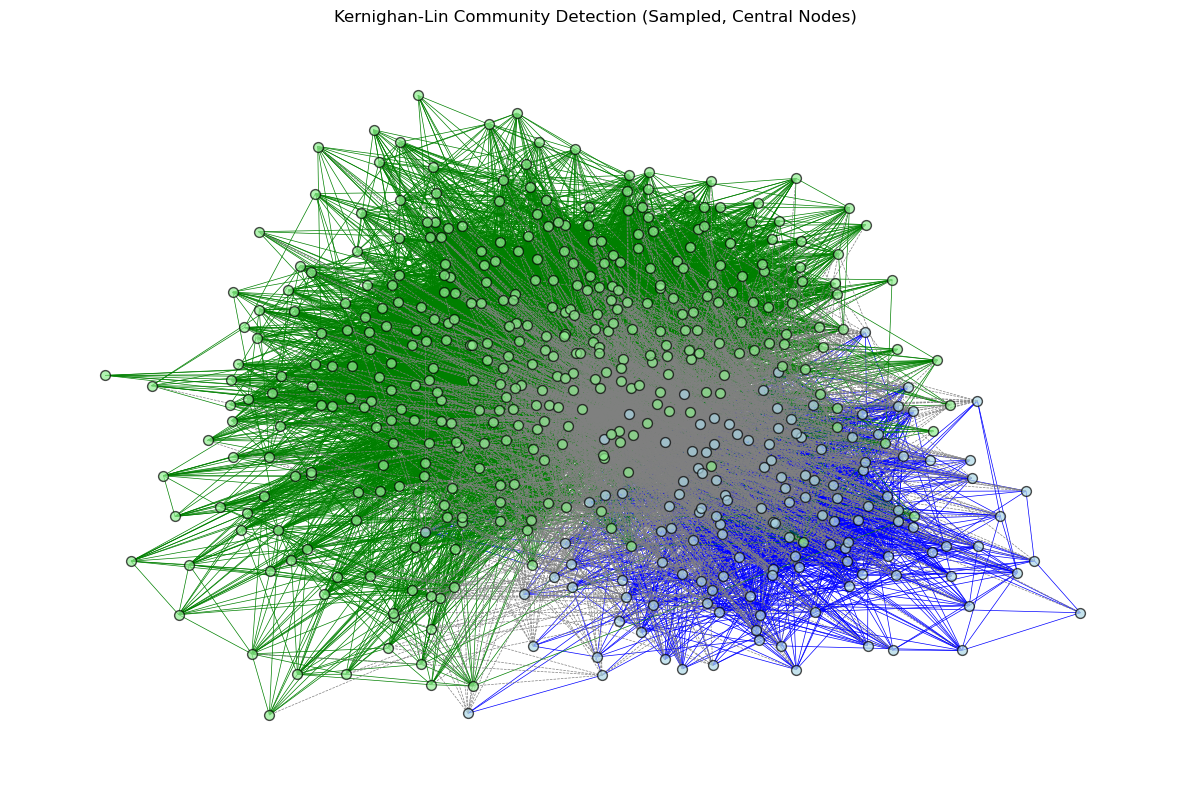

In [28]:
from networkx.algorithms.community import kernighan_lin_bisection

print(f"Subgraph for KL Partitioning: {len(G_sub.nodes())} nodes, {len(G_sub.edges())} edges")

# Run Kernighan-Lin Algorithm
print("Running Kernighan-Lin Bisection...")
partition = kernighan_lin_bisection(G_sub)
group_1, group_2 = partition

# Partitioning results
print(f"\nKernighan-Lin Partition Results:")
print(f"Group 1 Size: {len(group_1)} nodes")
print(f"Group 2 Size: {len(group_2)} nodes")

# Check if the Top 2 nodes Are in different groups
if top_nodes[0] in group_1 and top_nodes[1] in group_2:
    print(f"Node {top_nodes[0]} is in Group 1, and Node {top_nodes[1]} is in Group 2.")
elif top_nodes[0] in group_2 and top_nodes[1] in group_1:
    print(f"Node {top_nodes[0]} is in Group 2, and Node {top_nodes[1]} is in Group 1.")
else:
    print("The top two nodes are in the same group.")

# Overlap statistics / shared neighbors
shared_neighbors = neighbors_1 & neighbors_2
print(f"\nNumber of Shared Neighbors Between Node {top_nodes[0]} and Node {top_nodes[1]}: {len(shared_neighbors)}")

# Visualizing the KL Partitioning (sampled, central nodes)
sample_size = 500
degree_centrality = nx.degree_centrality(G_sub)
sorted_nodes = sorted(
    degree_centrality.items(),
    key=lambda x: (-x[1], x[0])  # sort by centrality (desc), then node id
)
sample_nodes = [n for n, _ in sorted_nodes[:sample_size]]
G_sampled = G_sub.subgraph(sample_nodes)
pos = nx.spring_layout(G_sampled, k=0.2, seed=87)
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_sampled, pos, nodelist=[node for node in sample_nodes if node in group_1], 
                       node_color='lightblue', label="Group 1", node_size=50, alpha=0.7, edgecolors='black')
nx.draw_networkx_nodes(G_sampled, pos, nodelist=[node for node in sample_nodes if node in group_2], 
                       node_color='lightgreen', label="Group 2", node_size=50, alpha=0.7, edgecolors='black')
nx.draw_networkx_edges(G_sampled, pos, edgelist=[(u, v) for u, v in G_sampled.edges() if u in group_1 and v in group_1], 
                       edge_color='blue', width=0.5)
nx.draw_networkx_edges(G_sampled, pos, edgelist=[(u, v) for u, v in G_sampled.edges() if u in group_2 and v in group_2], 
                       edge_color='green', width=0.5)
nx.draw_networkx_edges(G_sampled, pos, edgelist=[(u, v) for u, v in G_sampled.edges() if (u in group_1 and v in group_2) or (u in group_2 and v in group_1)], 
                       edge_color='gray', width=0.5, style='dashed')
plt.title("Kernighan-Lin Community Detection (Sampled, Central Nodes)")
plt.axis('off')
plt.tight_layout()
plt.savefig("images/kl_sample.png", dpi=300, bbox_inches="tight")
plt.show()


**Commentary:**

KL produces a balanced split of the subgraph into two groups. The two dominant hubs fall into different partitions, consistent with KL’s objective of reducing cross-community connections. 

In the sampled visualisation, each partition forms a dense region, while the dashed gray edges highlight the connectivity that still bridges the two sides. This suggests the split is present but not perfectly separated, an idea we quantify next using modularity.

### 3.4 Partition Diagnostics and Modularity

We now evaluate the quality of the KL partition along three dimensions:

**1. Label Composition**  
We compare the distribution of ML vs web developers in each group to assess whether connectivity-based communities align with developer type.

**2. Connectivity Profile**  
We compute the average degree within each group and among shared neighbours to understand how densely connected each partition is.

**3. Modularity**  
Modularity quantifies how well the partition separates the graph by comparing the density of intra-group edges to inter-group edges.  
Higher values indicate stronger structural separation.

In [29]:
# ML vs Web Developer Distribution within KL communities
def developer_distribution(group):
    ml_count = sum(G.nodes[n].get("ml_target", -1) == 1 for n in group)
    web_count = sum(G.nodes[n].get("ml_target", -1) == 0 for n in group)
    return ml_count, web_count

ml_group1, web_group1 = developer_distribution(group_1)
ml_group2, web_group2 = developer_distribution(group_2)
ml_shared, web_shared = developer_distribution(shared_neighbors)

print(f"Group 1 - ML Developers: {ml_group1}, Web Developers: {web_group1}")
print(f"Group 2 - ML Developers: {ml_group2}, Web Developers: {web_group2}")
print(f"Shared Neighbors - ML Developers: {ml_shared}, Web Developers: {web_shared}")

# Degree comparison within KL communities
def degree_stats(group):
    degrees = [G.degree(n) for n in group]
    return {"avg_degree": sum(degrees) / len(degrees), "max_degree": max(degrees)}

degree_group1 = degree_stats(group_1)
degree_group2 = degree_stats(group_2)
degree_shared = degree_stats(shared_neighbors)

print(f"Group 1 - Avg Degree: {degree_group1['avg_degree']:.2f}")
print(f"Group 2 - Avg Degree: {degree_group2['avg_degree']:.2f}")
print(f"Shared Neighbors - Avg Degree: {degree_shared['avg_degree']:.2f}, Max Degree: {degree_shared['max_degree']}")

Group 1 - ML Developers: 1546, Web Developers: 5520
Group 2 - ML Developers: 1097, Web Developers: 5969
Shared Neighbors - ML Developers: 241, Web Developers: 2170
Group 1 - Avg Degree: 17.19
Group 2 - Avg Degree: 42.24
Shared Neighbors - Avg Degree: 65.52, Max Degree: 3324


**Commentary:**

Both KL groups contain a mix of ML and web developers, indicating that the partition is not strongly aligned with developer type. The split is therefore structural rather than label-driven. 

Group 1 exhibits a substantially higher average degree than Group 2, suggesting it contains the denser core of the hub neighbourhood.

Shared neighbours display the highest average degree, confirming that the overlapping region between the two hubs is structurally dense and likely acts as a bridging layer between communities.

In [30]:
from networkx.algorithms.community.quality import modularity

# Calculate modularity of the subgraph 
partition_list = [group_1, group_2]
modularity_value = modularity(G_sub, partition_list)

# Display the modularity result
print(f"Modularity of the KL Partition: {modularity_value:.4f}")

Modularity of the KL Partition: 0.2504


**Commentary:**

The modularity score (~0.25) indicates moderate community structure.

While the KL algorithm successfully separates the subgraph into two internally dense groups, the relatively modest modularity value suggests that cross-group connectivity remains significant.

This supports the visual interpretation: the partition is present, but the boundary between communities is not sharply defined.

### 3.5 Robustness: Removing the Dominant Hubs

To assess how dependent the overall network is on the two most central nodes, we remove them and recompute:

- number of connected components
- size of the largest connected component

This provides a simple robustness check: whether the network fragments substantially when key hubs are removed.

In [18]:
# Remove Top 2 nodes
G_copy = G.copy()
G_copy.remove_nodes_from([31890, 27803])

# Calculate the number of connected components
components_after_removal = nx.number_connected_components(G_copy)
print(f"Connected Components After Removing Top Nodes: {components_after_removal}")

# Calculate the size of the largest connected component after removal
largest_cc_after_removal = max(nx.connected_components(G_copy), key=len)
print(f"Largest Connected Component Size After Removal: {len(largest_cc_after_removal)}")

# Compute the sizes of all connected components
components = list(nx.connected_components(G_copy))
component_sizes = [len(c) for c in components]

# Sum up all nodes across components
total_nodes_after_removal = sum(component_sizes)
print(f"Total Nodes in All Components After Removal: {total_nodes_after_removal}")

Connected Components After Removing Top Nodes: 508
Largest Connected Component Size After Removal: 37178
Total Nodes in All Components After Removal: 37698


**Commentary:**

Removing the two most influential hubs increases the number of connected components substantially, indicating that these nodes act as important structural bridges. However, the largest connected component remains overwhelmingly dominant (37,178 nodes out of 37,698 total). This suggests that while the hubs contribute to connectivity, the network is not critically dependent on them for global cohesion.

In other words:

- The hubs enhance connectivity and reduce fragmentation.
- But the network retains a robust backbone even in their absence.

This highlights an important structural property: the GitHub developer network is hub-influenced but not hub-fragile.

## 4. Representation Learning and Unsupervised Structure

In the previous section, communities were detected using purely connectivity-based methods. We now move to a *feature-learning approach*, where nodes are embedded into a vector space.

### 4.1 Node2Vec Embeddings

Node2Vec is a graph embedding algorithm that learns vector representations of nodes by simulating biased random walks over the graph. Importantly, these embeddings are learned **purely from network structure** — not from the original node attributes (location, starred repositories, employer, etc.). The algorithm only observes how nodes are connected.

Intuitively:

- Random walks generate sequences of nodes, similar to sentences in natural language.
- Nodes that frequently appear in similar walk contexts receive similar vector representations.
- As a result, structurally similar nodes — even if not directly connected — may end up close in embedding space.

This allows the embedding to capture:

- Local neighbourhood similarity
- Broader connectivity patterns
- Structural equivalence between nodes

We generate 64-dimensional embeddings for nodes in the hub-centred subgraph (`G_sub`).

To ensure reproducibility and efficiency:
- Embeddings are saved to `outputs/node2vec_embeddings.csv`
- If the file already exists, it is loaded instead of recomputed

These embeddings form the basis for downstream dimensionality reduction and clustering analysis.

In [19]:
import os
from node2vec import Node2Vec
from multiprocessing import cpu_count

embeddings_file = "outputs/node2vec_embeddings.csv"

if os.path.exists(embeddings_file):
    embeddings = pd.read_csv(embeddings_file, index_col=0)
    print("Loaded pre-saved node2vec embeddings from CSV.")
else:
    print("Running node2vec to generate embeddings...")

    node2vec = Node2Vec(
        G_sub,
        dimensions=64,
        walk_length=10,
        num_walks=50,
        workers=cpu_count(),
        quiet=False
    )

    model = node2vec.fit(
        window=10,
        min_count=1,
        batch_words=4
    )

    valid_nodes = [node for node in G_sub.nodes() if node in model.wv]

    embeddings = pd.DataFrame(
        [model.wv[node] for node in valid_nodes],
        index=valid_nodes
    )

    embeddings.to_csv(embeddings_file)
    print(f"Node2Vec embeddings generated and saved to {embeddings_file}.")

Loaded pre-saved node2vec embeddings from CSV.


### 4.2 PCA Projection of Node2Vec Embeddings

The learned Node2Vec embeddings are 64-dimensional vectors. To visualise their structure, we project them into 2 dimensions using Principal Component Analysis (PCA).

PCA is a linear dimensionality reduction technique that:

- Identifies directions of maximum variance in the data
- Projects high-dimensional vectors into a lower-dimensional space
- Preserves as much global structure as possible

We first visualise the embeddings without labels, and then overlay the previously obtained KL partition to compare the Connectivity-based communities (KL) and  Embedding-space structure (Node2Vec).

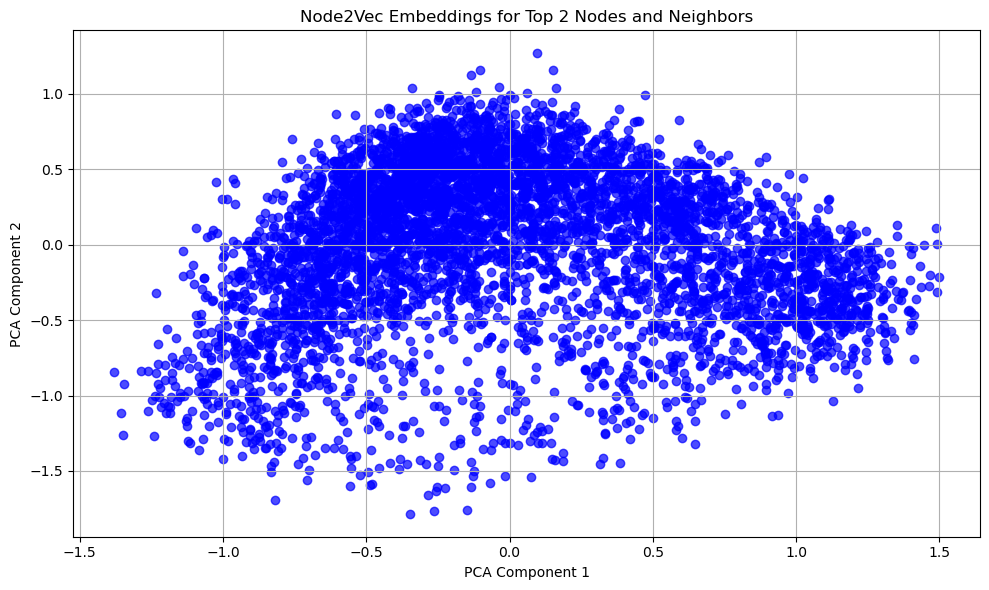

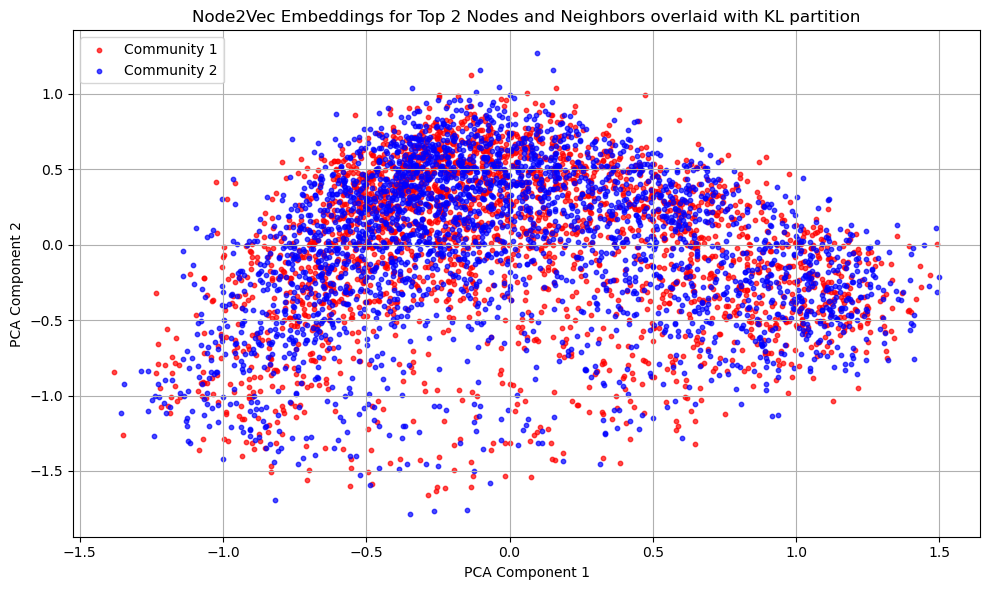

In [26]:
from sklearn.decomposition import PCA

# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the Embeddings by PCA
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', alpha=0.7)
plt.title("Node2Vec Embeddings for Top 2 Nodes and Neighbors", fontsize=12)
plt.xlabel("PCA Component 1", fontsize=10)
plt.ylabel("PCA Component 2", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("images/pca.png", dpi=300, bbox_inches="tight")
plt.show()

# Overlaying with KL partition
community_1_color = 'red'
community_2_color = 'blue'
node_colors = []
for node in embeddings.index:  
    if node in group_1:
        node_colors.append(community_1_color)
    else:
        node_colors.append(community_2_color)
node_colors = np.array(node_colors)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[node_colors == community_1_color, 0], 
            reduced_embeddings[node_colors == community_1_color, 1], 
            color=community_1_color, alpha=0.7, s=10, label="Community 1")

plt.scatter(reduced_embeddings[node_colors == community_2_color, 0], 
            reduced_embeddings[node_colors == community_2_color, 1], 
            color=community_2_color, alpha=0.7, s=10, label="Community 2")
plt.title("Node2Vec Embeddings for Top 2 Nodes and Neighbors overlaid with KL partition", fontsize=12)
plt.xlabel("PCA Component 1", fontsize=10)
plt.ylabel("PCA Component 2", fontsize=10)
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("images/pca_kl_overlay.png", dpi=300, bbox_inches="tight")
plt.show()


**Commentary:**

When colouring by KL community membership, the two partitions are heavily interwoven in embedding space.

There is no clear linear separation between the two KL groups, indicating that:

- The connectivity-based split does not map cleanly onto embedding similarity.
- Node2Vec captures richer structural context beyond a simple two-way partition.

This suggests that while KL identifies a connectivity-based bisection, the learned feature space does not necessarily yield the same structural relationships.

### 4.3 t-SNE Projection of Node2Vec Embeddings

While PCA preserves global variance through linear projection, t-SNE (t-Distributed Stochastic Neighbor Embedding) is a non-linear method designed to preserve *local neighbourhood structure*.

Key differences:

- PCA captures global structure and overall variance.
- t-SNE emphasises local similarity and can reveal subtle cluster structure.

We apply t-SNE to examine whether tighter local groupings emerge in embedding space and whether these align with the KL partition.

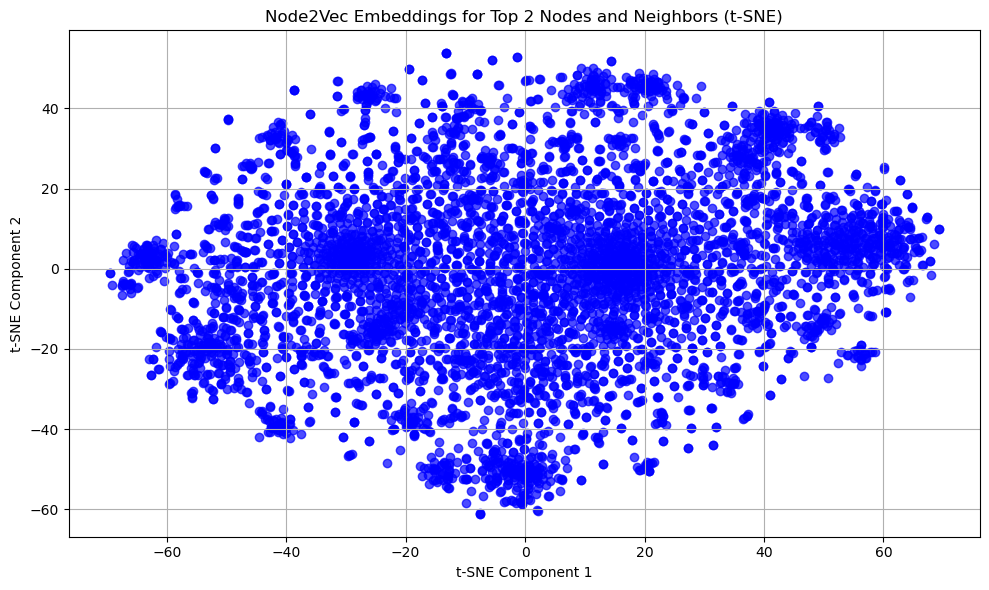

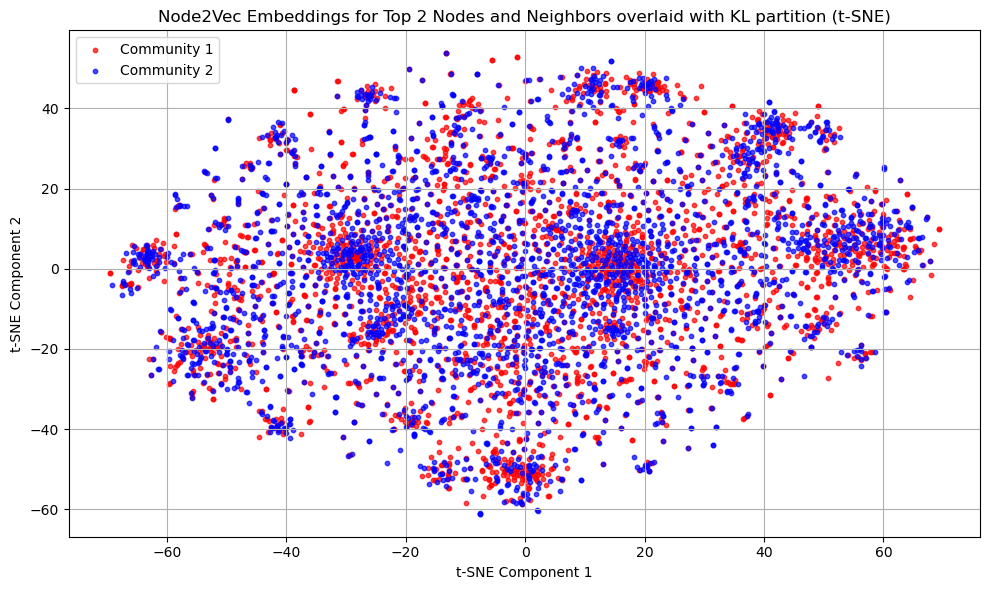

In [27]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=55, n_jobs=-1)  
reduced_embeddings_tsne = tsne.fit_transform(embeddings)

# Visualize the Embeddings by t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c='blue', alpha=0.7)
plt.title("Node2Vec Embeddings for Top 2 Nodes and Neighbors (t-SNE)", fontsize=12)
plt.xlabel("t-SNE Component 1", fontsize=10)
plt.ylabel("t-SNE Component 2", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("images/tsne.png", dpi=300, bbox_inches="tight")
plt.show()

# Overlaying with KL partition
community_1_color = 'red'
community_2_color = 'blue'
node_colors = []
for node in embeddings.index:  
    if node in group_1:
        node_colors.append(community_1_color)
    else:
        node_colors.append(community_2_color)
node_colors = np.array(node_colors)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[node_colors == community_1_color, 0], 
            reduced_embeddings_tsne[node_colors == community_1_color, 1], 
            color=community_1_color, alpha=0.7, s=10, label="Community 1")

plt.scatter(reduced_embeddings_tsne[node_colors == community_2_color, 0], 
            reduced_embeddings_tsne[node_colors == community_2_color, 1], 
            color=community_2_color, alpha=0.7, s=10, label="Community 2")
plt.title("Node2Vec Embeddings for Top 2 Nodes and Neighbors overlaid with KL partition (t-SNE)", fontsize=12)
plt.xlabel("t-SNE Component 1", fontsize=10)
plt.ylabel("t-SNE Component 2", fontsize=10)
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("images/tsne_kl_overlay.png", dpi=300, bbox_inches="tight")
plt.show()


**Commentary:**

Despite clearer local clusters in t-SNE space, the KL communities remain heavily intermixed. This reinforces the earlier observation that connectivity-based bisection does not correspond to a clean separation in embedding space.

### 4.4 Clustering in Embedding Space (K-Means)

So far, we have:

- Partitioned the graph using a connectivity-based algorithm (Kernighan–Lin)
- Observed that KL communities do not separate cleanly in embedding space

This raises an interesting question: *If we ignore the connectivity partition and instead cluster directly in the learned embedding space, do we recover a clearer structural separation?*

To test this, we apply K-Means clustering directly to the 64-dimensional Node2Vec embeddings.

Why K-Means?

- Node2Vec maps nodes into a vector space.
- If meaningful communities exist in this space, they should form geometrically separable clusters.
- K-Means provides a simple way to test whether the embedding naturally divides into two compact groups.

By comparing K-Means clusters with the earlier KL partition, we can evaluate whether embedding similarity reflects the same structure as graph partitioning or whether representation learning captures a different notion of community

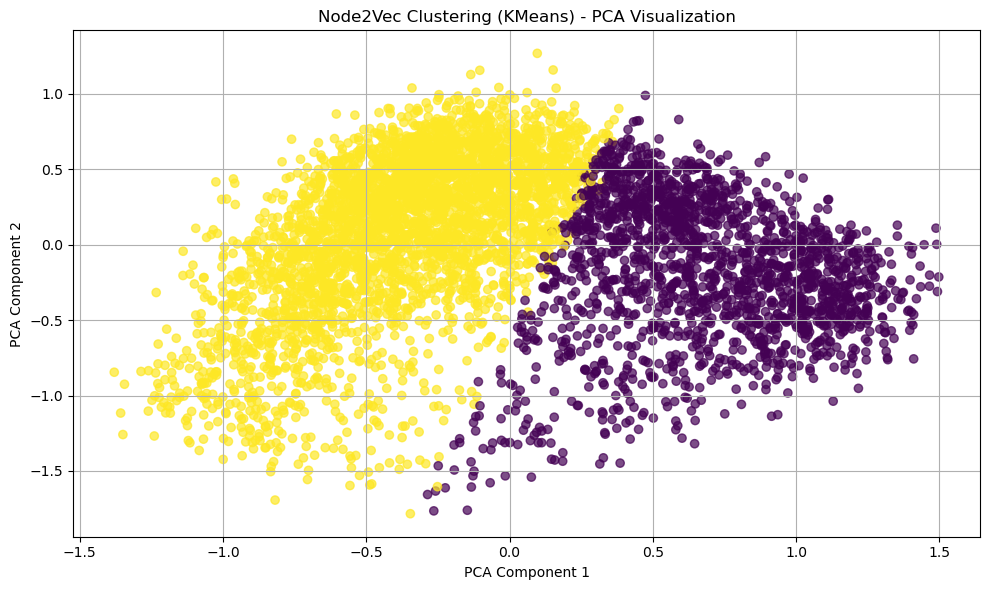

In [ ]:
from sklearn.cluster import KMeans

# Apply KMeans clustering on Node2Vec embeddings (64D)
kmeans = KMeans(n_clusters=2, random_state=98)
kmeans_labels = kmeans.fit_predict(embeddings)  # embeddings from Node2Vec

# Plot PCA visualization with clustering
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("Node2Vec Clustering (KMeans) - PCA Visualization", fontsize=12)
plt.xlabel("PCA Component 1", fontsize=10)
plt.ylabel("PCA Component 2", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("images/pca_kmeans.png", dpi=300, bbox_inches="tight")
plt.show()

**Commentary:**

Unlike the KL overlay, K-Means produces a much cleaner geometric separation in PCA space.

The embedding naturally divides into two compact regions, suggesting that Node2Vec has captured a latent structural split that is more linearly separable than the connectivity-based KL partition.

This indicates that similarity in embedding space may reflect broader structural roles rather than strict edge-minimisation boundaries.

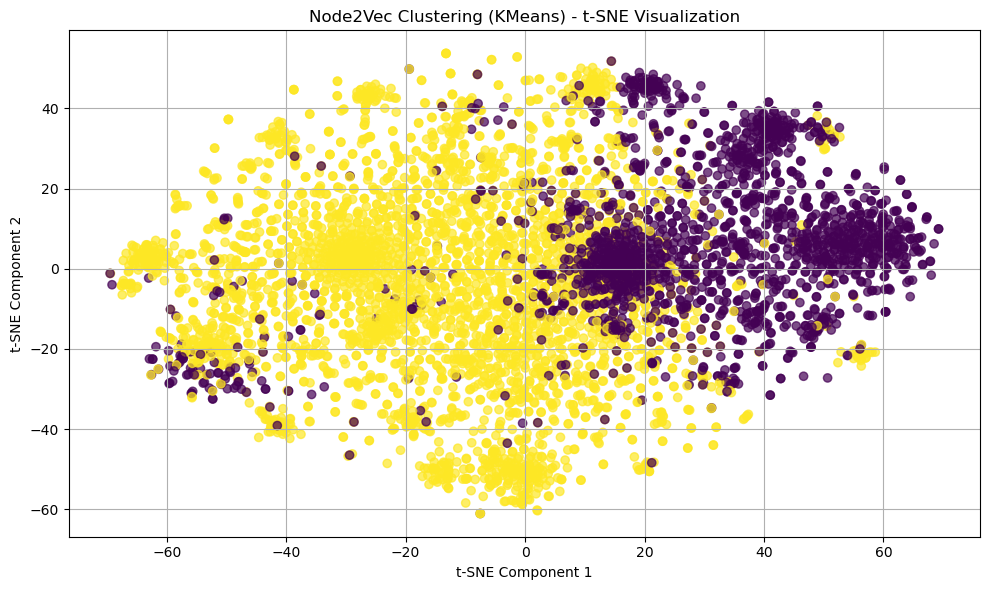

In [24]:
# Plot t-SNE visualization with clustering
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("Node2Vec Clustering (KMeans) - t-SNE Visualization", fontsize=12)
plt.xlabel("t-SNE Component 1", fontsize=10)
plt.ylabel("t-SNE Component 2", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("images/tsne_kmeans.png", dpi=300, bbox_inches="tight")
plt.show()

**Commentary:**

In t-SNE space, the K-Means clusters remain visually coherent and locally concentrated. This contrasts sharply with the KL overlay, where community labels appeared heavily intermixed.

The result suggests that:

- Embedding space contains meaningful cluster structure.
- Connectivity-based bisection (KL) does not fully align with the higher-order relational patterns captured by Node2Vec.

In other words, representation learning reveals structure that simple graph partitioning does not isolate cleanly.

## 5. Conclusion

This project explored community structure in a GitHub developer network through two complementary lenses:

- A **connectivity-driven approach** (Kernighan–Lin partitioning)
- A **representation learning approach** (Node2Vec embeddings)

Structurally, the network is strongly hub-driven. A small number of developers act as highly connected bridges linking large portions of the graph. Removing the two most central nodes increases fragmentation, but the giant component remains overwhelmingly dominant. This suggests the network is influenced by hubs, yet not critically dependent on any single pair of nodes for global connectivity.

When examining community structure, the picture becomes more nuanced.

The KL partition identifies a structural split within the hub-centred subgraph, but this division does not cleanly separate in embedding space. In contrast, clustering directly on Node2Vec embeddings produces more geometrically coherent groupings.

For this GitHub network in particular, the results imply that:

- Developers are not neatly divided into two isolated communities.
- Highly connected users share overlapping follower neighbourhoods.
- Structural similarity patterns extend beyond strict connectivity partitions.
- Developer type (web vs ML) does not strongly determine structural grouping.

Overall, the network appears densely interconnected, with influence distributed through overlapping neighbourhoods rather than sharply separated blocks.

TIn practical terms, this highlights an important modelling choice:

> If we define community strictly by edge density, we see one structure.  
> If we define community by structural similarity in learned space, we see another.

Both views are valid — but they answer different questions about how the network is organised.

This comparison demonstrates how classical network analysis and modern graph embeddings provide complementary tools for understanding complex relational data.